###Libraries and common functions

In [ ]:
import numpy as np
import sympy
import math
import scipy
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython import display
#from qiskit.visualization import plot_bloch_vector
from sympy import Matrix
from sympy.physics.quantum import TensorProduct

Pauli operators

In [ ]:
Id = np.matrix([[1 , 0],[0 , 1]])
sx = np.matrix([[0 , 1] , [1 , 0]])
sy = np.matrix([[0 , -1j] , [1j , 0]])
sz = np.matrix([[1,0] , [0,-1]])
pauli_1Q=[Id,sx,sy,sz]

fidelity and purity

In [ ]:
def fidelity(mean_state,state):
  return np.real(np.trace(scipy.linalg.sqrtm(np.matmul(mean_state,state))))**2

In [ ]:
def mean_fidelity(n,weights,particuls,mean_state):
  mean=0
  for i in range(n):
    mean=np.real(weights[i])*fidelity(mean_state,particuls[i])+mean
  return mean


In [ ]:
def var_fidelity(mean,n,weights,particuls,mean_state):
  var=0
  for i in range(n):
    var=np.real(weights[i])*((fidelity(mean_state,particuls[i])-mean)**2)+var
  return var


In [ ]:
def purity(state):
  return np.real(np.trace(np.matmul(state,state)))

support functions

In [ ]:
def to_string(lis):
  strn=""
  l=[0 for i in range(len(lis))]
  for i in range(len(lis)):
    if(lis[i]-1>=0):
      l[lis[i]-1]=1
  for i in reversed(range(len(l))):
    strn+=str(l[i])
  return strn

In [ ]:
possible_values=dict()

def values(lis,n):
  possible_values[to_string(lis)]=0
  if lis[0]==n:
    return
  i=n-1
  while(i>=0 and lis[i]+1>n):
    lis[i]=0
    i=i-1
  lis[i]=lis[i]+1
  values(lis,n)

In [ ]:
possible_values

{}

In [ ]:
vec=list(possible_values.keys())
vec

[]

coordinates on the bloch sphere and radius

In [ ]:
def frobenius_coordinates(state,pauli):
  return np.real(np.trace(np.matmul(state.H,pauli)))

In [ ]:
def find_radius(cor):
  sum=0
  for i in range(len(cor)):
    sum=sum+cor[i]**2

  return np.sqrt(sum) 

In [ ]:
number_of_qubits=1

In [ ]:
values([0 for i in range((number_of_qubits))],(number_of_qubits))

In [ ]:
E=[np.matrix([[int(i==j==k) for i in range(len(possible_values))] for k in range(len(possible_values))]) for j in range(len(possible_values))]

In [ ]:
list_mesure = [E[i%(2**number_of_qubits)] for i in range((2**number_of_qubits+1)*len(possible_values))]

In [ ]:
def to_index(res):
  index_vec=[]
  for i in range(len(res)):
    j=0
    while j<res[i]:
      j=j+1
      index_vec.append(i)
  return index_vec

SMC

In [ ]:
def Sequential_MC(N_particuls, list_Mesure, list_instance,toll):
  N_mesurement = len(list_instance)
  random.shuffle(list_instance)
  Seff=1
  number_res=0

  particuls = sample_uniform_sphere(N_particuls)
  weights = [1/N_particuls] * N_particuls

  for i in range(N_mesurement):
    outcome = list_Mesure[list_instance[i]]  
    f=int(list_instance[i]/(2**number_of_qubits))
    for part in range(N_particuls):
            p=np.matmul(operators[f],np.matmul(particuls[part],operators[f].H))
            prod=np.trace(p.dot(outcome)).real
            weights[part] = prod * weights[part]
    
    weight_total_nextstep = np.sum(weights)
    for k in range(N_particuls):
        weights[k] = weights[k] / weight_total_nextstep

    Wsq=0
    for m in range(N_particuls):
       Wsq=Wsq+weights[m]**2
    Seff=1/Wsq
    if(Seff/N_particuls<toll):
        number_res=number_res+1
        res=np.random.multinomial(N_particuls,pvals=weights)
        particuls=resampling(res,particuls)
        weights = [1/N_particuls] * N_particuls
        Seff=1

  return particuls,weights

jittering, consider using the first or the third

In [ ]:
def jittering(state):
  lamda,theta,phi=np.random.normal(0, 0.005),np.random.normal(0, 0.005),np.random.normal(0, 0.005)
  U=np.matrix([[np.cos(theta/2), -np.exp(1j*lamda)*np.sin(theta/2)],[np.exp(1j*phi)*np.sin(theta/2), np.exp(1j*(lamda+phi))*np.cos(theta/2)]])
  K=[[int(i==j) if (i>1 or j>1) else U[i,j] for i in range(2**number_of_qubits)] for j in range(2**number_of_qubits)]
  K=np.matrix(K)
  P=np.matrix(np.random.normal( size = ( 2**number_of_qubits, 2**number_of_qubits ),scale=0.005 ) + 1j * np.random.normal( size = ( 2**number_of_qubits, 2**number_of_qubits ),scale=0.005 ))
  P,r=np.linalg.qr(P)
  U=np.matmul(P,np.matmul(K,np.linalg.inv(P)))
  K=np.matmul(U,np.matmul(state,U.H))
  id=np.matrix(np.eye(2**number_of_qubits))
  M=np.matrix(np.random.normal( size = ( 2**number_of_qubits, 2**number_of_qubits ),scale=0.005 ) + 1j * np.random.normal( size = ( 2**number_of_qubits, 2**number_of_qubits ),scale=0.005 ))
  F=np.matmul(np.matmul((id+M),K),(id+M.H))/np.trace(np.matmul(np.matmul((id+M),K),(id+M.H)))
  return np.matmul(np.matmul((id+M),K),(id+M.H))/np.trace(np.matmul(np.matmul((id+M),K),(id+M.H)))

In [ ]:
def jittering(state):
  pauli_base=[]
  pauli_kQ=np.copy(pauli_1Q)
  for k in range(number_of_qubits-1):
    pauli_kpQ=[]
    for i in pauli_kQ:
       for j in pauli_1Q:
          pauli_kpQ.append(np.matrix(TensorProduct(i,j)))
    pauli_kQ=np.copy(pauli_kpQ)
  pauli_base=[np.matrix(i) for i in pauli_kQ]
  
  coor=np.array([frobenius_coordinates(state,pauli) for pauli in pauli_base[1:]])
  rho=find_radius(coor)
  new_rho=rho+np.random.normal(0,0.01)
  if new_rho>1:
    new_rho=1
  if new_rho<0:
    new_rho=0

  coor=coor/rho*new_rho

  lamda,theta,phi=np.random.normal(0, 0.01),np.random.normal(0, 0.01),np.random.normal(0, 0.01)
  U=np.matrix([[np.cos(theta/2), -np.exp(1j*lamda)*np.sin(theta/2)],[np.exp(1j*phi)*np.sin(theta/2), np.exp(1j*(lamda+phi))*np.cos(theta/2)]])
  K=[[int(i==j) if (i>1 or j>1) else U[i,j] for i in range(2**number_of_qubits)] for j in range(2**number_of_qubits)]
  K=np.matrix(K)
  P=np.matrix(np.random.normal( size = ( 2**number_of_qubits, 2**number_of_qubits ),scale=0.01 ) + 1j * np.random.normal( size = ( 2**number_of_qubits, 2**number_of_qubits ),scale=0.01 ))
  P,r=np.linalg.qr(P)
  U=np.matmul(P,np.matmul(K,np.linalg.inv(P)))
  K=np.matmul(U,np.matmul(state,U.H))



  return np.matrix(K)



In [ ]:
def jittering(state):
  epsilon=np.random.beta(0.5,35)
  gamma=np.random.beta(0.5,20)
  lev=sample_uniform_sphere(1)[0]
  new_state=(1-epsilon-gamma)*state+epsilon*lev+gamma*(state/np.sqrt(purity(state)+0.000001)+(1-1/np.sqrt(purity(state)+0.000001))*np.matrix(np.eye(2**number_of_qubits,2**number_of_qubits))/(2**number_of_qubits))

  return new_state


  

Sample from the haar measure

In [ ]:
def Haar_sampling(N):
  l =[0] * N
  for i in range(N):
    M = np.random.normal( size = ( 2**number_of_qubits, 2**number_of_qubits ) ) + 1j * np.random.normal( size = ( 2**number_of_qubits, 2**number_of_qubits ) )
    X = M.dot(M.conj().T)
    l[i] = np.matrix(X/ np.trace(X))
  return l

Sample uniformly inside the sphere

In [ ]:
def sample_uniform_sphere(n):
  l=[0]*n
  for i in range(n):
    U=Haar_sampling(1)[0]
    A=np.matrix(np.random.normal( size = ( 2**number_of_qubits, 2**number_of_qubits ) ) + 1j * np.random.normal( size = ( 2**number_of_qubits, 2**number_of_qubits ) ))
    A=A/np.sqrt(2**number_of_qubits)
    id=np.matrix(np.eye(2**number_of_qubits))
    l[i]=np.matmul(np.matmul((id+U),np.matmul(A,A.H)),(id+U.H))/np.trace(np.matmul(np.matmul((id+U),np.matmul(A,A.H)),(id+U.H)))
  return l



In [ ]:
def resampling(res,particuls):
  par=particuls
  res=to_index(res)
  for i in range(len(res)):
    par[i]=jittering(particuls[res[i]])
  return par


In [ ]:
def sample_posterior(weights,particuls):
  part=particuls[np.where(np.random.multinomial(1, weights)>0)[0][0]]
  return part

###QISKIT

In [ ]:
!pip install qiskit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 39.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 59.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.3/241.3 KB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.3/54.3 KB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.0/107.0 KB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.5/37.5 MB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 41.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 KB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 KB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 65.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.7/112.7 KB 

In [ ]:
#!pip install qiskit
from qiskit import *
from qiskit.tools.monitor import job_monitor
from numpy import pi
from qiskit import Aer
from qiskit.circuit.random import random_circuit
import qiskit.quantum_info as qi



class experiments():
    def __init__(self,n_of_shots,n_of_qubits,real=0,random=0):
        self.n_of_shots=n_of_shots
        self.n_of_qubits=n_of_qubits
        self.random=random
        self.operators=[]
        self.real_state=0
        
        self.shots=n_of_shots
        if real==0:
            self.simulated=[0]*(2**n_of_qubits+1)
            for i in range(2**n_of_qubits+1):
              self.simulate(i)
        if real==1:
            self.res=[0]*(2**n_of_qubits+1)
            for i in range(2**n_of_qubits+1):
              self.rl(i)
        
    def simulate(self,op_number):
        qr=QuantumRegister(self.n_of_qubits)
        cr=ClassicalRegister(self.n_of_qubits)
        circuit=QuantumCircuit(qr,cr)

        self.real_state=np.matrix([[1 if i==j==0 else 0 for i in range(2**self.n_of_qubits)] for j in range(2**self.n_of_qubits)])
        for i in range(self.n_of_qubits):
            circuit.h(qr[i])
            circuit.barrier(qr[i])
        
        self.real_state=np.matmul(np.matrix(qi.Operator(circuit)),np.matmul(self.real_state,np.matrix(qi.Operator(circuit)).H))
        if self.random==0:
            qr1=QuantumRegister(self.n_of_qubits)
            cr1=ClassicalRegister(self.n_of_qubits)
            circuit1=QuantumCircuit(qr1,cr1)
                
            if op_number<2**self.n_of_qubits:
                for i in range(self.n_of_qubits):
                  if(vec[op_number][i]=="0"):
                      circuit.h(qr[i])
                      circuit1.h(qr1[i])
                  else:
                      circuit1.u(pi / 2, 0, pi / 2, qr1[i])
                      circuit.u(pi / 2, 0, pi / 2, qr[i])
                self.operators.append(qi.Operator(circuit1))
                
            else:
                self.operators.append(qi.Operator(circuit1))

        
        else:
            circuit1=random_circuit(self.n_of_qubits, 3,3)
            self.operators.append(qi.Operator(circuit1))
            circuit.compose(circuit1,inplace=True)
            
        circuit.measure(qr,cr)

        simulator=Aer.get_backend("qasm_simulator")
        result=execute(circuit,backend=simulator,shots=self.shots).result()
        self.simulated[op_number]=result.get_counts(circuit)
        
    def rl(self,op_number):
        qr=QuantumRegister(self.n_of_qubits)
        cr=ClassicalRegister(self.n_of_qubits)
        circuit=QuantumCircuit(qr,cr)
        
        for i in range(self.n_of_qubits):
            circuit.h(qr[i])
            circuit.barrier(qr[i])
        
        if self.random==0:
            qr1=QuantumRegister(self.n_of_qubits)
            cr1=ClassicalRegister(self.n_of_qubits)
            circuit1=QuantumCircuit(qr1,cr1)
                
            if op_number<2**self.n_of_qubits:
                for i in range(self.n_of_qubits):
                  if(vec[op_number][i]=="0"):
                      circuit.h(qr[i])
                      circuit1.h(qr1[i])
                  else:
                      circuit1.u(pi / 2, 0, pi / 2, qr1[i])
                      circuit.u(pi / 2, 0, pi / 2, qr[i])
                self.operators.append(qi.Operator(circuit1))
                
            else:
                self.operators.append(qi.Operator(circuit1))

        
        else:
            circuit1=random_circuit(self.n_of_qubits, 3,3)
            self.operators.append(qi.Operator(circuit1))
            circuit.compose(circuit1,inplace=True)
            
        circuit.measure(qr,cr)
        
        IBMQ.load_account()
        provider=IBMQ.get_provider("ibm-q")
        qcomp=provider.get_backend("ibmq_belem")
        job=execute(circuit,backend=qcomp,shots=self.shots)
        job_monitor(job)
        result=job.result()
        self.res[op_number]=result.get_counts(circuit)
        
ex1=experiments(500, number_of_qubits,0,0)
for i in range(2**number_of_qubits+1):
  print(ex1.simulated[i])
  print("------------")
  print(ex1.operators[i])
        
        
        
        
        
        

IndexError: ignored

In [ ]:
print(ex1.real_state)

[[0.5+0.j 0.5+0.j]
 [0.5+0.j 0.5+0.j]]


In [ ]:
possible_values

{'0': 0, '1': 0}

the experiment could not have some results, but for the algorithm to work we need full support

In [ ]:
for i in possible_values.keys():
  for j in range(2**number_of_qubits+1):
    if(ex1.simulated[j].get(i)==None):
      ex1.simulated[j][i]=0


create a list of measurements, each unique element of the support in each configuration will have a unique identifier 

In [ ]:
mesur_list=[]
k=-1
for i in range(2**number_of_qubits+1):
    for j in possible_values:
      k=k+1
      for m in range(ex1.simulated[i][j]):
        mesur_list.append(k)

we need a list of 2^n measurements for each 2^n+1 basis

In [ ]:
operators=ex1.operators

1qubit measurement operator basis

In [ ]:
H=np.matrix([[1/np.sqrt(2),1/np.sqrt(2)],[1/np.sqrt(2),-1/np.sqrt(2)]])
U=np.matrix([[1/np.sqrt(2),-1j/np.sqrt(2)],[1/np.sqrt(2),1j/np.sqrt(2)]])
I=np.matrix(np.eye(2))

In [ ]:
if number_of_qubits==2:
  operators=[np.matrix(TensorProduct(H,H)),np.matrix(TensorProduct(U,H)),np.matrix(TensorProduct(H,U)),np.matrix(TensorProduct(U,U)),np.matrix(TensorProduct(I,I))]

In [ ]:
for i in range(2**number_of_qubits+1):
  operators[i]=np.matrix(operators[i])

SMC

In [ ]:
Id = np.matrix([[1 , 0],[0 , 1]])
sx = np.matrix([[0 , 1] , [1 , 0]])
sy = np.matrix([[0 , -1j] , [1j , 0]])
sz = np.matrix([[1,0] , [0,-1]])
pauli_1Q=[Id,sx,sy,sz]

SMC

In [ ]:
toll=0.3
n=500
particuls,weights = Sequential_MC(n,list_mesure,mesur_list,toll)

In [ ]:
order = np.argsort(weights)
weight_ordered = [weights[k] for k in order]
particul_ordered = [particuls[k] for k in order]

In [ ]:
Level_of_confidence = 0.95

In [ ]:
mean_state=ex1.real_state

In [ ]:
sum = 0
rank = 0
N = len(weights)
while (rank < N) and (sum < Level_of_confidence):
  sum += weights[-rank-1]
  rank += 1

In [ ]:
rank

482

In [ ]:
max = np.amax(weights)
print(max)
s = np.sum(weights)
print(s)

0.006159423986235773
1.0000000000000002


In [ ]:
Id = np.matrix([[1 , 0],[0 , 1]])
sx = np.matrix([[0 , 1] , [1 , 0]])
sy = np.matrix([[0 , -1j] , [1j , 0]])
sz = np.matrix([[1,0] , [0,-1]])

In [ ]:
def measure(ρ):
    Id = np.matrix([[1 , 0],[0 , 1]])
    sx = np.matrix([[0 , 1] , [1 , 0]])
    sy = np.matrix([[0 , -1j] , [1j , 0]])
    sz = np.matrix([[1,0] , [0,-1]])    
    x = np.trace(np.dot(ρ, sx)).real
    y = np.trace(np.dot(ρ, sy)).real
    z = np.trace(np.dot(ρ, sz)).real
    return [x, y, z]

In [ ]:
R = [measure(rho) for rho in particuls]

plots (only 1qubit supported)

/usr/local/lib/python3.8/dist-packages/mpl_toolkits/mplot3d/art3d.py:304: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self._segments3d = np.asanyarray(segments)


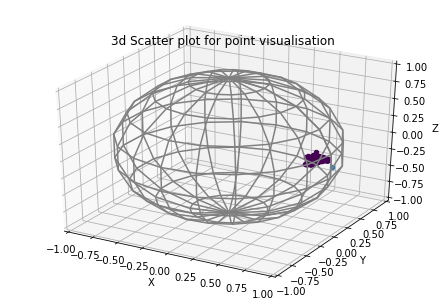

In [ ]:
import qutip
#plot with color for weight visualisation
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
import matplotlib.animation as animation
 
fig = plt.figure()

N = len(particuls)
# max = np.amax(weigths)

b = qutip.Bloch3d() #if it gives problem use qubip.Bloch() instead and remove the last commands(b. ect)
x, y, z = [], [], []
# syntax for 3-D projection
for i in range(N):
  #c = ((1-weigths[i]/max),(1-weigths[i]/max), (1-weigths[i]/max))
    c = (0,0,0)
    p = measure(particuls[i])
    z.append(p[2])
    x.append(p[0])
    y.append(p[1])
  #ax.scatter(x, y, z, c = weights[i]*255*10)


b.add_points([x,y,z],alpha=1)
b.point_color=['#3a7cbd']
b.point_size=0.035



b.show()

###DISTRIBUTION ON ONE QUBIT

In [ ]:
def insightful_sampling(alpha,beta,D,mean_state):
  eps=np.random.beta(alpha,beta)
  rho_f=np.matrix(Haar_sampling(1)[0])
  rho_star=(alpha+beta)/alpha*(mean_state-beta/((alpha+beta)*D)*np.eye(D))
  rho_s=(1.0-eps)*rho_f+eps*rho_star*np.trace(rho_f)
  return rho_s


sample a random state,give the paramethers of the distribution

In [ ]:
def insightful_sampling_spherical(alpha_rho,beta_rho,alpha_theta,beta_theta,alpha_phi,beta_phi):
    Id = np.matrix([[1 , 0],[0 , 1]])
    sx = np.matrix([[0 , 1] , [1 , 0]])
    sy = np.matrix([[0 , -1j] , [1j , 0]])
    sz = np.matrix([[1,0] , [0,-1]])

    phi=math.pi*np.random.beta(alpha_phi,beta_phi)
    theta=2*math.pi*np.random.beta(alpha_theta,beta_theta)-math.pi

    rho=np.random.beta(alpha_rho,beta_rho)

    sigmaz=math.cos(phi)*rho
    sigmay=math.sin(theta)*math.sin(phi)*rho
    sigmax=math.sin(phi)*math.cos(theta)*rho

    return 0.5*(Id+sigmax*sx+sigmay*sy+sigmaz*sz)


In [ ]:
def mean_purity_distr(trials):
  mean=0
  for i in range(trials):
    part_distr=insightful_sampling_spherical(9,1,400,400,200,200)
    mean=mean+purity(part_distr)
  mean=mean/trials
  return mean

In [ ]:
H=np.matrix([[1/np.sqrt(2), 1/np.sqrt(2)],[1/np.sqrt(2), -1/np.sqrt(2)]])
U=np.matrix([[1/np.sqrt(2), -1j/np.sqrt(2)],[1/np.sqrt(2), 1j/np.sqrt(2)]])

create an experiment,give the number of experiments required and the paramethers on the distribution

In [ ]:
class random_experiments():
  def __init__(self,experiment_number,alpha_rho,beta_rho,alpha_theta,beta_theta,alpha_phi,beta_phi):
    self.n=experiment_number
    self.alpha_rho=alpha_rho
    self.beta_rho=beta_rho
    self.alpha_theta=alpha_theta
    self.beta_theta=beta_theta
    self.alpha_phi=alpha_phi
    self.beta_phi=beta_phi
    self.Xsimulated=dict()
    self.Ysimulated=dict()
    self.Zsimulated=dict()
    self.Xsimulated["0"]=0
    self.Xsimulated["1"]=0
    self.Ysimulated["0"]=0
    self.Ysimulated["1"]=0
    self.Zsimulated["0"]=0
    self.Zsimulated["1"]=0
    self.particuls=[insightful_sampling_spherical(alpha_rho,beta_rho,alpha_theta,beta_theta,alpha_phi,beta_phi) for i in range(self.n)]

    for i in range(self.n):
      res=np.random.binomial(1,np.real(self.particuls[i][1,1]))
      if res==1:
        self.Zsimulated["1"]=self.Zsimulated["1"]+1
      else:
        self.Zsimulated["0"]=self.Zsimulated["0"]+1
      tr_X=np.matmul(H,np.matmul(self.particuls[i],H.H))
      res=np.random.binomial(1,np.real(tr_X[1,1]))
      if res==1:
        self.Xsimulated["1"]=self.Xsimulated["1"]+1
      else:
        self.Xsimulated["0"]=self.Xsimulated["0"]+1
      tr_Y=np.matmul(U,np.matmul(self.particuls[i],U.H))
      res=np.random.binomial(1,np.real(tr_Y[1,1]))
      if res==1:
        self.Ysimulated["1"]=self.Ysimulated["1"]+1
      else:
        self.Ysimulated["0"]=self.Ysimulated["0"]+1


In [ ]:
N=300
e=random_experiments(N,9,1,400,400,200,200)

In [ ]:
particuls=e.particuls

In [ ]:
print(e.Xsimulated)
print(e.Ysimulated)
print(e.Zsimulated)

{'0': 284, '1': 16}
{'0': 149, '1': 151}
{'0': 151, '1': 149}


In [ ]:
Id = np.matrix([[1 , 0],[0 , 1]])
sx = np.matrix([[0 , 1] , [1 , 0]])
sy = np.matrix([[0 , -1j] , [1j , 0]])
sz = np.matrix([[1,0] , [0,-1]])

In [ ]:
def measure(ρ):
    Id = np.matrix([[1 , 0],[0 , 1]])
    sx = np.matrix([[0 , 1] , [1 , 0]])
    sy = np.matrix([[0 , -1j] , [1j , 0]])
    sz = np.matrix([[1,0] , [0,-1]])    
    x = np.trace(np.dot(ρ.H, sx)).real
    y = np.trace(np.dot(ρ.H, sy)).real
    z = np.trace(np.dot(ρ.H, sz)).real
    return [x, y, z]

In [ ]:
R = [measure(rho) for rho in particuls]

In [ ]:
!pip install qutip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━ 8.2/16.7 MB 76.6 MB/s eta 0:00:01
ERROR: Operation cancelled by user


In [ ]:
!pip install mayavi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Operation cancelled by user


plots of the sampled particles used to perform the experiment

In [ ]:
import qutip
#plot with color for weight visualisation
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
import matplotlib.animation as animation
 
fig = plt.figure()

N = len(particuls)
# max = np.amax(weigths)

b = qutip.Bloch()
x, y, z = [], [], []
# syntax for 3-D projection
for i in range(N):
  #c = ((1-weigths[i]/max),(1-weigths[i]/max), (1-weigths[i]/max))
    c = (0,0,0)
    p = measure(particuls[i])
    z.append(p[2])
    x.append(p[0])
    y.append(p[1])
  #ax.scatter(x, y, z, c = weights[i]*255*10)


b.add_points([x,y,z])


b.show()

ModuleNotFoundError: ignored

In [ ]:
mean_state=np.matrix([[0.5,0.45],[0.45,0.5]])

In [ ]:
#real mean fidelity around 0.9855157390463062

In [ ]:
 #real variance of fidelity around 0.00017857252076685165

In [ ]:
mesur_list=[]
k=-1
for i in range(3):
  if i==0:
    for j in possible_values:
      k=k+1
      for m in range(e.Xsimulated[j]):
        mesur_list.append(k)
  if i==1:
    for j in possible_values:
      k=k+1
      for m in range(e.Ysimulated[j]):
        mesur_list.append(k)
  if i==2:
    for j in possible_values:
      k=k+1
      for m in range(e.Zsimulated[j]):
        mesur_list.append(k)

SMC

In [ ]:
toll=0.2
n=500
particuls,weights = Sequential_MC(n,list_mesure,mesur_list,toll)

In [ ]:
order = np.argsort(weights)
weight_ordered = [weights[k] for k in order]
particul_ordered = [particuls[k] for k in order]

In [ ]:
R = [measure(rho) for rho in particuls]

In [ ]:
x=np.random.multinomial(1, [1/6.]*6)
print(x)
f=np.where(x>0)
f[0][0]

In [ ]:
def fidelity_distr_posterior(weights,particuls,trials):
  mean=0
  for i in range(trials):
    part_posterior=sample_posterior(weights,particuls)
    part_distr=insightful_sampling_spherical(9,1,400,400,200,200)
    mean=fidelity(part_posterior,part_distr)+mean
  mean=mean/trials
  return mean

In [ ]:
def mean_purity_post(weights,particuls):
  length=len(particuls)
  mean=0
  for i in range(length):
    mean=purity(particuls[i])*weights[i]+mean
  return mean

plot of the final distribution

In [ ]:
import qutip
#plot with color for weight visualisation
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
import matplotlib.animation as animation
 
fig = plt.figure()

N = len(particuls)
# max = np.amax(weigths)

b = qutip.Bloch3d()
x, y, z = [], [], []
# syntax for 3-D projection
for i in range(N):
  #c = ((1-weigths[i]/max),(1-weigths[i]/max), (1-weigths[i]/max))
    c = (0,0,0)
    p = measure(particuls[i])
    z.append(p[2])
    x.append(p[0])
    y.append(p[1])
  #ax.scatter(x, y, z, c = weights[i]*255*10)


b.add_points([x,y,z],alpha=1)
b.point_color=['#3a7cbd']
b.point_size=0.035



b.show()

purity of the true distribution and of the posterior

In [ ]:
pur_distr=mean_purity_distr(10000)
pur_distr

In [ ]:
pur_post=mean_purity_post(weights,particuls)
pur_post

In [ ]:
m=fidelity_distr_posterior(weights,particuls,10000)
m

###TWO QUBITS CASE

In [ ]:
H=np.matrix([[1/np.sqrt(2),1/np.sqrt(2)],[1/np.sqrt(2),-1/np.sqrt(2)]])
U=np.matrix([[1/np.sqrt(2),-1j/np.sqrt(2)],[1/np.sqrt(2),1j/np.sqrt(2)]])
I=np.matrix(np.eye(2))

In [ ]:
operators=[np.matrix(TensorProduct(H,H)),np.matrix(TensorProduct(U,H)),np.matrix(TensorProduct(H,U)),np.matrix(TensorProduct(U,U)),np.matrix(TensorProduct(I,I))]

In [ ]:
Id = np.matrix([[1 , 0],[0 , 1]])
sx = np.matrix([[0 , 1] , [1 , 0]])
sy = np.matrix([[0 , -1j] , [1j , 0]])
sz = np.matrix([[1,0] , [0,-1]])
pauli_1Q=[Id,sx,sy,sz]

In [ ]:
pauli_1Q=[Id,sx,sy,sz]

create 4D operators by taking the tensor product of the pauli matrices

In [ ]:
ang_coor=[0]*15
pauli_2Q=[]
for i in range(4):
  for j in range(4):
    pauli_2Q.append(np.matrix(TensorProduct(pauli_1Q[i],pauli_1Q[j])))

generate a random quantum state

this part of the code must be used after having run the general functions with 2 qubits

In [ ]:
def generate():
  for i in range(13):
    ang_coor[i]=math.pi*np.random.beta(200,200)
  ang_coor[13]=2*math.pi*np.random.beta(400,400)

  rho=np.random.beta(9,1)
  coor=[rho]*15
  for i in range(14):
    for j in range(i+1):
      if(i==j):
        coor[i]=coor[i]*math.cos(ang_coor[j])
      else:
        coor[i]=coor[i]*math.sin(ang_coor[j])

  for i in range(14):
    coor[14]=coor[14]*math.sin(ang_coor[i])

  state=pauli_2Q[0]
  for i in range(15):
    state=state+coor[i]*pauli_2Q[i+1]
  state=state/4
  return state


In [ ]:
def fidelity_distr_posterior(weights,particuls,trials):
  mean=0
  for i in range(trials):
    part_posterior=sample_posterior(weights,particuls)
    part_distr=generate()
    mean=fidelity(part_posterior,part_distr)+mean
  mean=mean/trials
  return mean

In [ ]:
def measure(state):
  prob=[0]*4
  for i in range(3):
    prob[i]=np.real(state[i,i])
  prob[3]=1-prob[0]-prob[1]-prob[2]
  return  np.random.multinomial(1,prob)

In [ ]:
pos=dict()
pos[0]="00"
pos[1]="01"
pos[2]="10"
pos[3]="11"





exp=dict()
exp["00"]=0
exp["01"]=0
exp["10"]=0
exp["11"]=0

In [ ]:

def experiment():
  state=generate()
  results=[]
  for i in range(5):
    T_state=np.matmul(operators[i],np.matmul(state,operators[i].H))
    x=measure(T_state)
    results.append(x)
  return results


In [ ]:
class random_experiments():
  def __init__(self,n):
    self.n=n
    self.simulated=[exp.copy() for i in range(5)]

    for j in range(self.n):
      result=experiment()
      for i in range(5):
          self.simulated[i][pos[np.where(result[i]>0)[0][0]]]=self.simulated[i][pos[np.where(result[i]>0)[0][0]]]+1

In [ ]:
ex1=random_experiments(1000)

In [ ]:
ex1.simulated

[{'00': 241, '01': 271, '10': 233, '11': 255},
 {'00': 243, '01': 267, '10': 255, '11': 235},
 {'00': 246, '01': 251, '10': 243, '11': 260},
 {'00': 227, '01': 270, '10': 257, '11': 246},
 {'00': 257, '01': 221, '10': 264, '11': 258}]

In [ ]:
mesur_list=[]
k=-1
for i in range(2**number_of_qubits+1):
    for j in possible_values:
      k=k+1
      for m in range(ex1.simulated[i][j]):
        mesur_list.append(k)

In [ ]:
toll=0
n=5000
particuls,weights = Sequential_MC(n,list_mesure,mesur_list,toll)

In [ ]:
m=fidelity_distr_posterior(weights,particuls,10000)
m

0.5956630174130433

4D operators requires 16 paramethers, we can't plot them easily on the sphere. To ease visualization we plot the partial trace

In [ ]:
def partial_trace(state):
  S=np.matrix([[0+1j*0,0+1j*0],[0+1j*0,0+1j*0]])
  S[0,0]=state[0,0]+state[1,1]
  S[0,1]=state[0,2]+state[1,3]
  S[1,0]=state[2,0]+state[3,1]
  S[1,1]=state[2,2]+state[3,3]
  return S

In [ ]:
def partial_trace_1(state):
    S=np.matrix([[0+1j*0,0+1j*0],[0+1j*0,0+1j*0]])
    S[0,0]=state[0,0]+state[2,2]
    S[0,1]=state[0,1]+state[2,3]
    S[1,0]=state[1,0]+state[3,2]
    S[1,1]=state[1,1]+state[3,3]
    return S

In [ ]:
p_trace = [partial_trace(i) for i in particuls]

In [ ]:
def measure(ρ):
    Id = np.matrix([[1 , 0],[0 , 1]])
    sx = np.matrix([[0 , 1] , [1 , 0]])
    sy = np.matrix([[0 , -1j] , [1j , 0]])
    sz = np.matrix([[1,0] , [0,-1]])    
    x = np.trace(np.dot(ρ, sx)).real
    y = np.trace(np.dot(ρ, sy)).real
    z = np.trace(np.dot(ρ, sz)).real
    return [x, y, z]

In [ ]:
import qutip
#plot with color for weight visualisation
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
import matplotlib.animation as animation
 
fig = plt.figure()

N = len(particuls)
# max = np.amax(weigths)

b = qutip.Bloch3d()
x, y, z = [], [], []
# syntax for 3-D projection
for i in range(N):
  #c = ((1-weigths[i]/max),(1-weigths[i]/max), (1-weigths[i]/max))
    c = (0,0,0)
    p = measure(p_trace[i])
    z.append(p[2])
    x.append(p[0])
    y.append(p[1])
  #ax.scatter(x, y, z, c = weights[i]*255*10)


b.add_points([x,y,z],alpha=1)
b.point_color=['#3a7cbd']
b.point_size=0.035



b.show()

ModuleNotFoundError: ignored